# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the two follow 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

In [13]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import re
import time
regex = re.compile(r"[^\w\d\s]")
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [2]:
#load data
df_yelp = pd.read_csv('/Users/thomaskelly/Documents/GitHub/text-mining-2020-classifying-text-tjknova/sentiment/yelps.csv')
df_yelp = df_yelp[['positive', 'text']]
df_yelp = df_yelp[df_yelp.positive.isin(['True', 'False'])]
df_yelp['positive'] = df_yelp['positive'].map({"True": True, "False": False}) #originally loaded as string
df_yelp.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 100002
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   positive  100000 non-null  bool  
 1   text      100000 non-null  object
dtypes: bool(1), object(1)
memory usage: 1.6+ MB


In [55]:
# trained on the entire dataset

tfidf = TfidfVectorizer(stop_words='english', min_df = 0.05, max_df=0.9)
X_yelp = tfidf.fit_transform(df_yelp['text'])
y_yelp = df_yelp['positive'] 


In [4]:
from sklearn.model_selection import train_test_split

testsize = [.99, 0.98, 0.96, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
logreg = LogisticRegression()
results_tfidf= []

for size in testsize:
    X_train, X_test, y_train, y_test = train_test_split(X_yelp, y_yelp, test_size=size, random_state=5)
    logreg.fit(X_train, y_train)
    logreg_pred = logreg.predict(X_test)
    logreg_insample = logreg.score(X_train, y_train)
    logreg_outofsample = accuracy_score(logreg_pred, y_test)
    results_tfidf.append([size, logreg_outofsample])
    
df_tfidf = pd.DataFrame(results_tfidf, columns= ['test size', 'tfidf accuracy'])
print(df_tfidf)

    test size  tfidf accuracy
0        0.99        0.858737
1        0.98        0.864296
2        0.96        0.868010
3        0.90        0.873211
4        0.80        0.874925
5        0.70        0.874786
6        0.60        0.875667
7        0.50        0.875700
8        0.40        0.876800
9        0.30        0.877200
10       0.20        0.875650


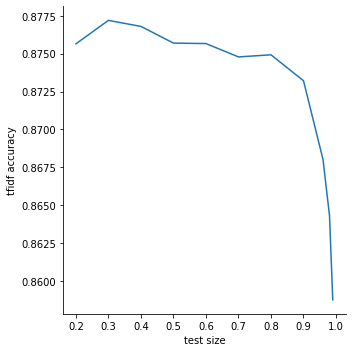

In [5]:
#graph accuracy

import seaborn as sns
import matplotlib.pyplot as plt

sns.relplot('test size', 'tfidf accuracy', data=df_tfidf, kind='line')
plt.show()

In [6]:
def process(doc):
    doc = re.sub(regex, '', doc)
    words = [stemmer.stem(word) for word in doc.split()]
    return ' '.join(words).lower()

sent = [process(doc) for doc in df_yelp['text']]
tokens = [word.split() for word in sent]

In [35]:
from gensim.models import Word2Vec
test =tokens[0:10000]

In [8]:
import multiprocessing
cores = multiprocessing.cpu_count()
print(cores)

4


In [37]:
#instantiate the model
w2v_model2 = Word2Vec(size=100, window=2, workers = cores-1, min_count=5)

In [38]:
# build the vocab

w2v_model2.build_vocab(tokens, progress_per=10000)


In [39]:
w2v_model2.train(test, total_examples=w2v_model2.corpus_count, epochs=10)

(8574346, 11661210)

In [77]:
def embed_word2vec(doc,model):
    result = np.zeros(100)
    
    for wrd in doc:
        try:
            wrd_emb = model.wv[wrd]
        except KeyError:
            wrd_emb = np.zeros(100)
    
        result += wrd_emb
    return result

In [78]:
W_yelp = np.array([x.split(' ') for x in df_yelp['text']])
x = embed_word2vec(W_yelp[0], w2v_model2)
print(x)

[-46.11836225  53.94695863 -46.72452487  27.15620043  44.94150508
 -68.768521    37.75898979   1.10352654 -16.98325172 -28.89881819
 -55.02354023  24.54488001 -60.29768557  -5.11362562 107.20497822
 -26.12961907  69.80093796  16.58655146 -27.81459333  48.27891504
   5.78921037   4.24761663  69.60859062  56.64904806  31.93491045
  17.74410339 -83.43911524  59.88570632   0.36416223 -40.74620924
   5.51147718  12.17084749  -9.58504656  72.79660879 -69.12055922
  19.2269065  -34.95950111  45.95212927 -12.2237101    9.29906718
  48.59241501 -44.29660375  32.58447268 101.12898683  38.29992261
  65.83509296   2.91768527 -19.53367606  30.21198783  41.13714385
  57.6391373  -29.31057893  73.14018838  17.02770031  14.41617234
  26.00347669  49.04046106 -13.63601403 -58.39134309  -4.59189305
  15.61542226  19.92564559 -52.17160721 -35.05113769 -78.04730809
 -66.8487003  -24.08399383  -6.42236793   0.14636276  15.29161119
  -5.26819525  40.2333908   10.5860124  -32.56665446  44.56501274
  44.93618

In [79]:
W_yelp_emb = np.array([embed_word2vec(doc,w2v_model2) for doc in W_yelp])


In [82]:
testsize = [.99, 0.98, 0.96, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
logreg2 = LogisticRegression()
results_w2v= []

for size in testsize:
    X_train, X_test, y_train, y_test = train_test_split(W_yelp_emb, y_yelp, test_size=size, random_state=5)
    logreg2.fit(X_train, y_train)
    logreg2_pred = logreg2.predict(X_test)
    logreg2_outofsample = accuracy_score(logreg2_pred, y_test)
    results_w2v.append([size, logreg2_outofsample])
    
df_w2v = pd.DataFrame(results_w2v, columns= ['test size', 'model2 w2v accuracy'])
print(df_w2v)

/Users/thomaskelly/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/thomaskelly/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

    test size  model2 w2v accuracy
0        0.99             0.818232
1        0.98             0.827224
2        0.96             0.837896
3        0.90             0.842867
4        0.80             0.845025
5        0.70             0.845143
6        0.60             0.844617
7        0.50             0.844840
8        0.40             0.843175
9        0.30             0.845033
10       0.20             0.847850


/Users/thomaskelly/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [83]:
df = pd.merge(df_tfidf, df_w2v, how='outer', on='test size')
print(df)

    test size  tfidf accuracy  model2 w2v accuracy
0        0.99        0.858737             0.818232
1        0.98        0.864296             0.827224
2        0.96        0.868010             0.837896
3        0.90        0.873211             0.842867
4        0.80        0.874925             0.845025
5        0.70        0.874786             0.845143
6        0.60        0.875667             0.844617
7        0.50        0.875700             0.844840
8        0.40        0.876800             0.843175
9        0.30        0.877200             0.845033
10       0.20        0.875650             0.847850


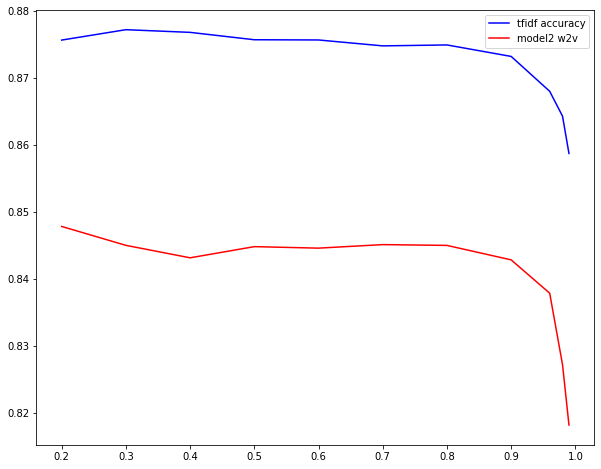

In [84]:
fig, ax = plt.subplots()
ax.plot(df['test size'], df['tfidf accuracy'], color='blue', label='tfidf accuracy')
ax.plot(df['test size'], df['model2 w2v accuracy'], color='red', label='model2 w2v')
fig.set_size_inches([10,8])
plt.legend()
plt.show()